# Capstone Project - The Battle of Neighborhoods

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

     |████████████████████████████████| 112kB 6.9MB/s eta 0:00:01
Libraries imported.


## Business Problem

In [2]:
#https://www.google.com/?code=ET20O4KXUVY40R01HEZ0C3MXVTXQPFESOPTGGAN4D3JCFPXQ#_=_
CLIENT_ID = 'O1VAWMONTH2GQ5MB1WYOSWR1IUCYU3C1ODPTYWIZQFNXWNTF' # your Foursquare ID
CLIENT_SECRET = 'LOX2OZZDHUQFVY1N2NEDLY0JS4QNIUWQYY0CPVYZJPFCWTKD' # your Foursquare Secret
ACCESS_TOKEN = 'HI5GYLJH05GATPAGPIQTKOSY4DYCV5CBX2G2DV2LWIP12WPE' # your FourSquare Access Token
VERSION = '20201010'
LIMIT = 30
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O1VAWMONTH2GQ5MB1WYOSWR1IUCYU3C1ODPTYWIZQFNXWNTF
CLIENT_SECRET:LOX2OZZDHUQFVY1N2NEDLY0JS4QNIUWQYY0CPVYZJPFCWTKD


### Defining Addresses of Interests

In [3]:
address1 = 'Lagos, NG'
address2 = 'Port-Harcourt, NG'

addresses = [address1,address2]

geolocator = Nominatim(user_agent="foursquare_agent")
geocode = lambda query: geolocator.geocode(query)
locations = []
for i,address in enumerate(addresses):
    locations.append(geocode(address))
    
for i,location in enumerate(locations):
    print("Location {} props are: ({},{},{})".format(i,location.latitude, location.longitude, location.address))

Location 0 props are: (6.4550575,3.3941795,Lagos, Lagos Island, 100242, Nigeria)
Location 1 props are: (4.7676576,7.0188527,Port-Harcourt, Rivers, Nigeria)


### Get venues close to target addresses

In [4]:
searchURL = 'https://api.foursquare.com/v2/venues/search'

venues = []
for i,location in enumerate(locations):
    url = '{}?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(searchURL,CLIENT_ID, CLIENT_SECRET, location.latitude, location.longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)
    venues.append(requests.get(url).json())

In [5]:
# assign relevant part of JSON to venues
#venues = results['response']['venues']
dfs = []
for i,venue in enumerate(venues):
    dfs.append(pd.json_normalize(venue['response']['venues']))
    print(dfs[i].shape)

(30, 16)
(30, 17)


In [6]:
dfs[0].head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet
0,4d62c4c414963704b89d0295,Dolphin Estate,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1610342319,False,lagos island,6.457817,3.396425,"[{'label': 'display', 'lat': 6.457817283681265...",395,NG,Lagos,Lagos,Nigeria,"[lagos island, Lagos, Lagos]",NaN
1,50701488e4b0bda4072f687b,Tinubu Square,"[{'id': '4bf58dd8d48988d162941735', 'name': 'O...",v-1610342319,False,Lagos Island,6.452689,3.389632,"[{'label': 'display', 'lat': 6.452689288537, '...",567,NG,Lagos,Lagos,Nigeria,"[Lagos Island, Lagos, Lagos]",NaN
2,515dcf94e4b090da56fe1074,Massey Street Children's Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1610342319,False,NaN,6.453578,3.393271,"[{'label': 'display', 'lat': 6.45357832974039,...",192,NG,Lagos,Lagos,Nigeria,"[Lagos, Lagos]",NaN
3,517e460e498e0661eaf966e7,Campbell Street,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",v-1610342319,False,Campbell Street,6.451513,3.392931,"[{'label': 'display', 'lat': 6.451512931096068...",418,NG,Lagos Island,Lagos,Nigeria,"[Campbell Street, Lagos Island, Lagos]",NaN
4,4fde19cde4b0e078038f4586,Iju Road Car Wash,"[{'id': '4f04ae1f2fb6e1c99f3db0ba', 'name': 'C...",v-1610342319,False,Iju Road Jungle B/Stop,6.453056,3.395833,"[{'label': 'display', 'lat': 6.4530556, 'lng':...",288,NG,Iju,Lagos,Nigeria,"[Iju Road Jungle B/Stop, Iju, Lagos]",NaN


## 1. Data Wrangling

### 1.1 keep only columns that include venue name, and anything that is associated with location 

In [7]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dfs[0].columns if col.startswith('location.')] + ['id']


# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


dfsFiltered = []
for i,df in enumerate(dfs):
    dfFiltered = df.loc[:, filtered_columns]
    # filter the category for each row
    dfFiltered['categories'] = dfFiltered.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    dfFiltered.columns = [column.split('.')[-1] for column in dfFiltered.columns]    
    dfsFiltered.append(dfFiltered)

In [8]:
dfsFiltered[0].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,crossStreet,id
0,Dolphin Estate,Residential Building (Apartment / Condo),lagos island,6.457817,3.396425,"[{'label': 'display', 'lat': 6.457817283681265...",395,NG,Lagos,Lagos,Nigeria,"[lagos island, Lagos, Lagos]",NaN,4d62c4c414963704b89d0295
1,Tinubu Square,Other Great Outdoors,Lagos Island,6.452689,3.389632,"[{'label': 'display', 'lat': 6.452689288537, '...",567,NG,Lagos,Lagos,Nigeria,"[Lagos Island, Lagos, Lagos]",NaN,50701488e4b0bda4072f687b
2,Massey Street Children's Hospital,Hospital,NaN,6.453578,3.393271,"[{'label': 'display', 'lat': 6.45357832974039,...",192,NG,Lagos,Lagos,Nigeria,"[Lagos, Lagos]",NaN,515dcf94e4b090da56fe1074
3,Campbell Street,Office,Campbell Street,6.451513,3.392931,"[{'label': 'display', 'lat': 6.451512931096068...",418,NG,Lagos Island,Lagos,Nigeria,"[Campbell Street, Lagos Island, Lagos]",NaN,517e460e498e0661eaf966e7
4,Iju Road Car Wash,Car Wash,Iju Road Jungle B/Stop,6.453056,3.395833,"[{'label': 'display', 'lat': 6.4530556, 'lng':...",288,NG,Iju,Lagos,Nigeria,"[Iju Road Jungle B/Stop, Iju, Lagos]",NaN,4fde19cde4b0e078038f4586


### 1.2 Remove other unnecessary columns

In [9]:
for i,dfFiltered in enumerate(dfsFiltered):
    dfFiltered.drop(['formattedAddress','crossStreet','id','labeledLatLngs'], axis=1, inplace=True)

In [10]:
dfsFiltered[0].head()

,name,categories,address,lat,lng,distance,cc,city,state,country
0,Dolphin Estate,Residential Building (Apartment / Condo),lagos island,6.457817,3.396425,395,NG,Lagos,Lagos,Nigeria
1,Tinubu Square,Other Great Outdoors,Lagos Island,6.452689,3.389632,567,NG,Lagos,Lagos,Nigeria
2,Massey Street Children's Hospital,Hospital,NaN,6.453578,3.393271,192,NG,Lagos,Lagos,Nigeria
3,Campbell Street,Office,Campbell Street,6.451513,3.392931,418,NG,Lagos Island,Lagos,Nigeria
4,Iju Road Car Wash,Car Wash,Iju Road Jungle B/Stop,6.453056,3.395833,288,NG,Iju,Lagos,Nigeria


### 1.3 Identify and handle missing values

In [11]:
for i,dfFiltered in enumerate(dfsFiltered):
    #dfFiltered.replace("NaN", np.nan, inplace = True)
    dfFiltered['address'].replace(np.nan, 'N/A', inplace=True)
    dfFiltered['categories'].replace('None', 'Others', inplace=True)
    # simply drop whole row with NaN in "price" column
    #dfFiltered.dropna(subset=["price"], axis=0, inplace=True)

    # reset index, because we droped two rows
    dfFiltered.reset_index(drop=True, inplace=True)

dfsFiltered[1]['state'].replace(np.nan, 'Rivers State', inplace=True)
dfsFiltered[1]['city'].replace(np.nan, 'Port Harcourt', inplace=True)

In [12]:
dfsFiltered[1].head()

,name,categories,address,lat,lng,distance,cc,city,state,country
0,"Port Harcourt, Nigeria",Monument / Landmark,N/A,4.773797,6.997869,2426,NG,Port Harcourt,Rivers State,Nigeria
1,Lagos Bus Stop,Bus Station,N/A,4.762569,7.019086,567,NG,Port Harcourt,Rivers State,Nigeria
2,State Secretariat,Government Building,N/A,4.773313,7.016391,686,NG,Port Harcourt,Rivers State,Nigeria
3,NNPC zonal office complex. Port harcourt,None,N/A,4.764687,7.020163,361,NG,Port Harcourt,Rivers State,Nigeria
4,NPA Port Harcourt,None,N/A,4.771236,7.010689,989,NG,Port Harcourt,Rivers State,Nigeria


### 1.4 Correct data format

Columns are the the correct data types

In [13]:
dfsFiltered[0].dtypes

name           object
categories     object
address        object
lat           float64
lng           float64
distance        int64
cc             object
city           object
state          object
country        object
dtype: object

## 2.0 Exploratory Analysis

### 2.1 Overview Analysis

In [14]:
dfsFiltered[0].describe()

,lat,lng,distance
count,30.000000,30.000000,30.000000
mean,6.452638,3.393209,504.866667
std,0.002763,0.003020,170.268497
min,6.447290,3.388653,153.000000
25%,6.451086,3.390777,397.500000
50%,6.452545,3.393197,505.000000
75%,6.453567,3.395539,618.500000
max,6.458800,3.398176,865.000000


In [15]:
dfsFiltered[1].describe()

,lat,lng,distance
count,30.000000,30.000000,30.000000
mean,4.772239,7.015372,1187.600000
std,0.007822,0.007720,674.217227
min,4.756186,6.997869,361.000000
25%,4.767233,7.012961,787.000000
50%,4.774091,7.013370,1059.000000
75%,4.775310,7.018721,1271.500000
max,4.791023,7.038834,3170.000000


### 2.2 Venues Category Frequencies

In [16]:
dfsFiltered[0][['categories']].value_counts()

categories                              
Building                                    3
Fast Food Restaurant                        2
Bank                                        2
Office                                      2
Electronics Store                           1
Art Gallery                                 1
Baseball Stadium                            1
Boat or Ferry                               1
Bridge                                      1
Car Wash                                    1
Church                                      1
City Hall                                   1
College Library                             1
Soccer Field                                1
Salad Place                                 1
Gas Station                                 1
Government Building                         1
Historic Site                               1
Hospital                                    1
Library                                     1
Other Great Outdoors                   

In [17]:
#dfsFiltered[1][['categories']].value_counts()

### 2.3 Histogram Plot of Frequencies

Text(0.5, 1.0, 'Venue Categories')

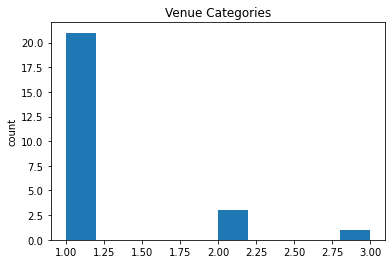

In [18]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
pyplot.hist(dfsFiltered[0][['categories']].value_counts())

# set x/y labels and plot title
#plt.pyplot.xlabel("categories")
plt.pyplot.ylabel("count")
plt.pyplot.title("Venue Categories")

Text(0.5, 1.0, 'Venue Categories')

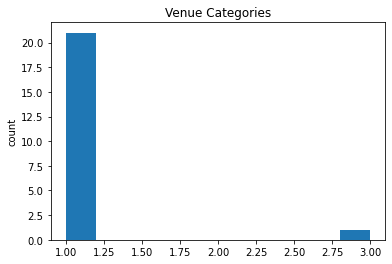

In [19]:
pyplot.hist(dfsFiltered[1][['categories']].value_counts())

# set x/y labels and plot title
#plt.pyplot.xlabel("categories")
plt.pyplot.ylabel("count")
plt.pyplot.title("Venue Categories")

Text(0.5, 1.0, 'Venue Categories')

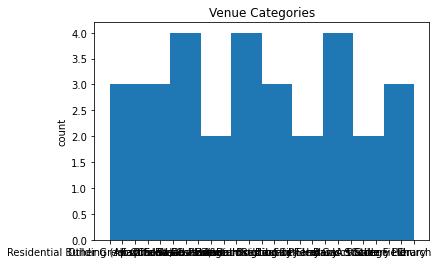

In [20]:
pyplot.hist(dfsFiltered[0]['categories'])

# set x/y labels and plot title
#plt.pyplot.xlabel("categories")
plt.pyplot.ylabel("count")
plt.pyplot.title("Venue Categories")

## 3.0 Making Map Plots

### Location 1 Venues Distribution

In [21]:
venueMaps = []
for i,dfFiltered in enumerate(dfsFiltered):
    tempMap = folium.Map(location=[locations[i].latitude, locations[i].longitude], zoom_start=15) # generate map centred around the Conrad Hotel

    # add a red circle marker to represent the Conrad Hotel
    folium.CircleMarker(
        [locations[i].latitude, locations[i].longitude],
        radius=10,
        color='red',
        popup=locations[i].address,
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(tempMap)
    
    # add the Italian restaurants as blue circle markers
    for lat, lng, label in zip(dfFiltered.lat, dfFiltered.lng, dfFiltered.categories):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color='blue',
            popup=label,
            fill = True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(tempMap)
    venueMaps.append(tempMap)
# display map
venueMaps[0]

### Location 2 Venues Distribution

In [22]:
venueMaps[1]

## 5.0 Clustering Neighbourhoods: k-Means

Run _k_-means to cluster the neighborhood into 5 clusters.

In [23]:
dfsFiltered[0].head()

,name,categories,address,lat,lng,distance,cc,city,state,country
0,Dolphin Estate,Residential Building (Apartment / Condo),lagos island,6.457817,3.396425,395,NG,Lagos,Lagos,Nigeria
1,Tinubu Square,Other Great Outdoors,Lagos Island,6.452689,3.389632,567,NG,Lagos,Lagos,Nigeria
2,Massey Street Children's Hospital,Hospital,N/A,6.453578,3.393271,192,NG,Lagos,Lagos,Nigeria
3,Campbell Street,Office,Campbell Street,6.451513,3.392931,418,NG,Lagos Island,Lagos,Nigeria
4,Iju Road Car Wash,Car Wash,Iju Road Jungle B/Stop,6.453056,3.395833,288,NG,Iju,Lagos,Nigeria


In [24]:
dfsOneHot = []
for i,dfFiltered in enumerate(dfsFiltered):
    dfsOneHot.append(pd.get_dummies(dfFiltered[['categories']], prefix="", prefix_sep=""))

    # add neighborhood column back to dataframe
    dfsOneHot[i]['state'] = dfFiltered['state'] 

    # move neighborhood column to the first column
    fixed_columns = [dfsOneHot[i].columns[-1]] + list(dfsOneHot[i].columns[:-1])
    dfsOneHot[i] = dfsOneHot[i][fixed_columns]

dfsOneHot[0].head()

,state,African Restaurant,Art Gallery,Bank,Baseball Stadium,Boat or Ferry,Bridge,Building,Car Wash,Church,...,Historic Site,Hospital,Library,Office,Other Great Outdoors,Pharmacy,Pier,Residential Building (Apartment / Condo),Salad Place,Soccer Field
0,Lagos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Lagos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Lagos,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Lagos,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Lagos,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
dfsOneHot[1].head()

,state,Airport,Bookstore,Bus Station,Capitol Building,Church,Cosmetics Shop,Discount Store,Golf Course,Government Building,...,Medical Center,Military Base,Monument / Landmark,Movie Theater,Pier,Pizza Place,Post Office,Shopping Mall,Supermarket,Track Stadium
0,Rivers State,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Rivers State,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rivers State,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Rivers State,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rivers State,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
dfsGrouped = []
for i,dfOneHot in enumerate(dfsOneHot):
    dfGrouped = dfOneHot.groupby('state').count().reset_index()
    dfsGrouped.append(dfGrouped)

dfsOneHot[0].head()


,state,African Restaurant,Art Gallery,Bank,Baseball Stadium,Boat or Ferry,Bridge,Building,Car Wash,Church,...,Historic Site,Hospital,Library,Office,Other Great Outdoors,Pharmacy,Pier,Residential Building (Apartment / Condo),Salad Place,Soccer Field
0,Lagos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Lagos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Lagos,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Lagos,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Lagos,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Let's print each neighborhood along with the top 5 most common venues

In [27]:
num_top_venues = 10

for hood in dfsGrouped[0]['state']:
    print("----"+hood+"----")
    temp = dfsGrouped[0][dfsGrouped[0]['state'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Lagos----
                                      venue  freq
0                        African Restaurant  30.0
1                               Gas Station  30.0
2                               Salad Place  30.0
3  Residential Building (Apartment / Condo)  30.0
4                                      Pier  30.0
5                                  Pharmacy  30.0
6                      Other Great Outdoors  30.0
7                                    Office  30.0
8                                   Library  30.0
9                                  Hospital  30.0




Thank you. Interpretation and conclusions are presented in the final report